# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Открытие и изучение файла

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('...')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
X = df.drop(columns=['is_ultra'])
X

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75
...,...,...,...,...
3209,122.0,910.98,20.0,35124.90
3210,25.0,190.36,0.0,3275.61
3211,97.0,634.44,70.0,13974.06
3212,64.0,462.32,90.0,31239.78


In [7]:
y = df['is_ultra']
y

0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64

In [8]:
y.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Данные преподготовлены, пустых значений нет, все колонки числовые. Соотношение пользователей тарифа "Ультра" к пользователям тарифа "Смарт" примерно 30:70. Выделен датасет с векторами предикторами (X) и вектором таргета (y).

## Разделение данных на выборки

In [9]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, 
                                                                y, 
                                                                test_size=0.4, 
                                                                stratify=y, 
                                                                random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, 
                                                    y_valid_test, 
                                                    test_size=0.5, 
                                                    stratify=y_valid_test, 
                                                    random_state=12345)

In [10]:
X_train.shape, X_valid.shape, X_test.shape

((1928, 4), (643, 4), (643, 4))

In [11]:
y_train.value_counts(normalize=True)

0    0.693465
1    0.306535
Name: is_ultra, dtype: float64

In [12]:
y_valid.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

X, y случаным образом со стратификацией по таргету разделены на три части (обучающая, валидационная, тестовая) в соотношении 60:20:20

## Исследование моделей

### DecisionTreeClassifier

In [14]:
max_depths = range(1, 31)
train_scores = []
valid_scores = []
best_max_depth = 0
best_score = 0
best_dt = None
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
    dt.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    valid_scores.append(accuracy_score(y_valid, dt.predict(X_valid)))
    score = accuracy_score(y_valid, dt.predict(X_valid))
    if score > best_score:
        best_score = score
        best_max_depth = max_depth
        best_dt = dt
print(f'Best max depth: {best_max_depth}, best accuracy on valid: {best_score}')

Best max depth: 8, best accuracy on valid: 0.80248833592535


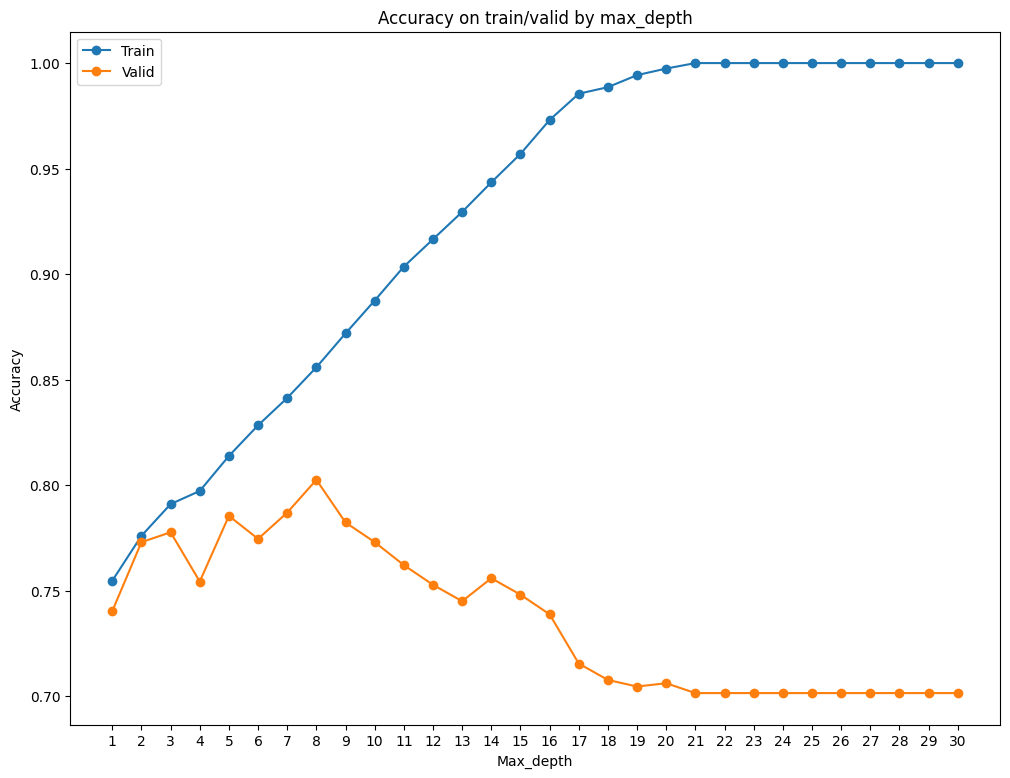

In [15]:
plt.figure(figsize=[12, 9])
plt.plot(max_depths, train_scores, 'o-', label='Train')
plt.legend(loc='upper left')
plt.plot(max_depths, valid_scores, 'o-', label='Valid')
plt.legend(loc='upper left')
plt.title('Accuracy on train/valid by max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths);

In [16]:
accuracy_score(y_valid[y_valid == 1], best_dt.predict(X_valid[y_valid == 1]))

0.5076142131979695

In [17]:
accuracy_score(y_valid[y_valid == 0], best_dt.predict(X_valid[y_valid == 0]))

0.9327354260089686

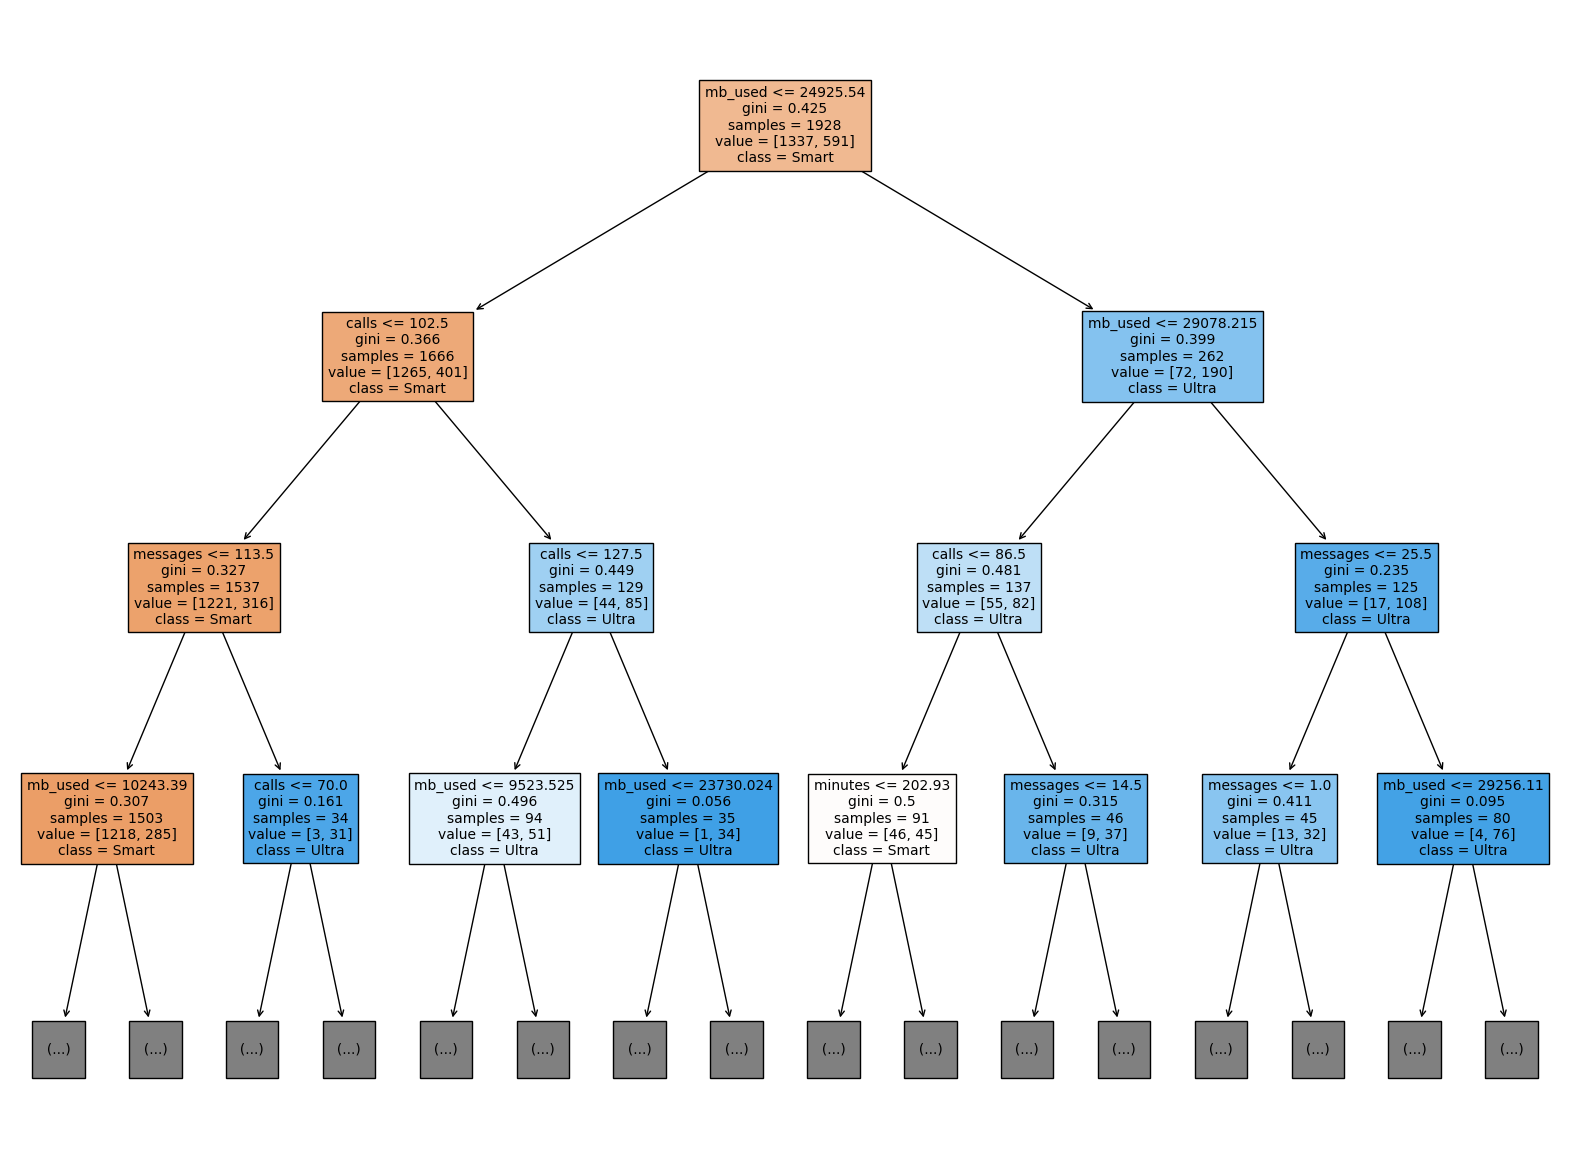

In [18]:
plt.figure(figsize=[20, 15])
plot_tree(best_dt, max_depth=3, class_names=['Smart', 'Ultra'], filled=True, fontsize=10, feature_names=X.columns);

Для DecisionTreeClassifier лучшее значение accuracy (0.8025) на валидационной выборке было получено при max_depth = 8. Причем для тарифа "Ультра" accuracy равно всего лишь 0.5076, а для тарифа "Смарт" 0.9327. Возможно, так получилось, потому что в наборе данных гораздо меньше данных о пользователях с тарифом "Ультра".

По графику изменения accuracy по max_depth видно, что для обучающей выборки accuracy равномерно растет с ростом глубины дерева и к глубине равной 21 принимает значение 1.

Для валидационной выборки accuracy достигает максимума при глубине дерева 8, затем падает.

При глубине дерева большей 8 модель становится переобученной и на новых данных выдает результаты гораздо хуже, чем на данных из обучающей выборки.

Первый сплит в дереве производится по признаку mb_used(израсходованный интернет-трафик в Мб), если mb_used <= 24925.54, то данные сплитуются по столбцу calls, в противном случае опять по столбцу mb_used. Из визуального представления дерева можно заметить, что пользователи, которые активнее пользуются всеми возможностями мобильной связи, чаще выбирают тариф "Ультра", чем тариф "Смарт".

### RandomForestClassifier

In [19]:
max_depths = range(1, 21)
n_estimators_list = range(5, 101, 5)
train_scores = pd.DataFrame(data=0, columns=max_depths, index=n_estimators_list)
valid_scores = pd.DataFrame(data=0, columns=max_depths, index=n_estimators_list)
best_max_depth = 0
best_n_estimators = 0
best_score = 0
best_rf = None
for n_estimators in n_estimators_list:
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1, random_state=12345)
        rf.fit(X_train, y_train)
        train_scores.loc[n_estimators, max_depth] = accuracy_score(y_train, rf.predict(X_train))
        valid_scores.loc[n_estimators, max_depth] = accuracy_score(y_valid, rf.predict(X_valid))
        score = accuracy_score(y_valid, rf.predict(X_valid))
        if score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_n_estimators = n_estimators
            best_rf = rf
print(f'Best max depth: {best_max_depth}, best n_estimators: {best_n_estimators}, best accuracy on valid: {best_score}')

Best max depth: 9, best n_estimators: 40, best accuracy on valid: 0.8211508553654744


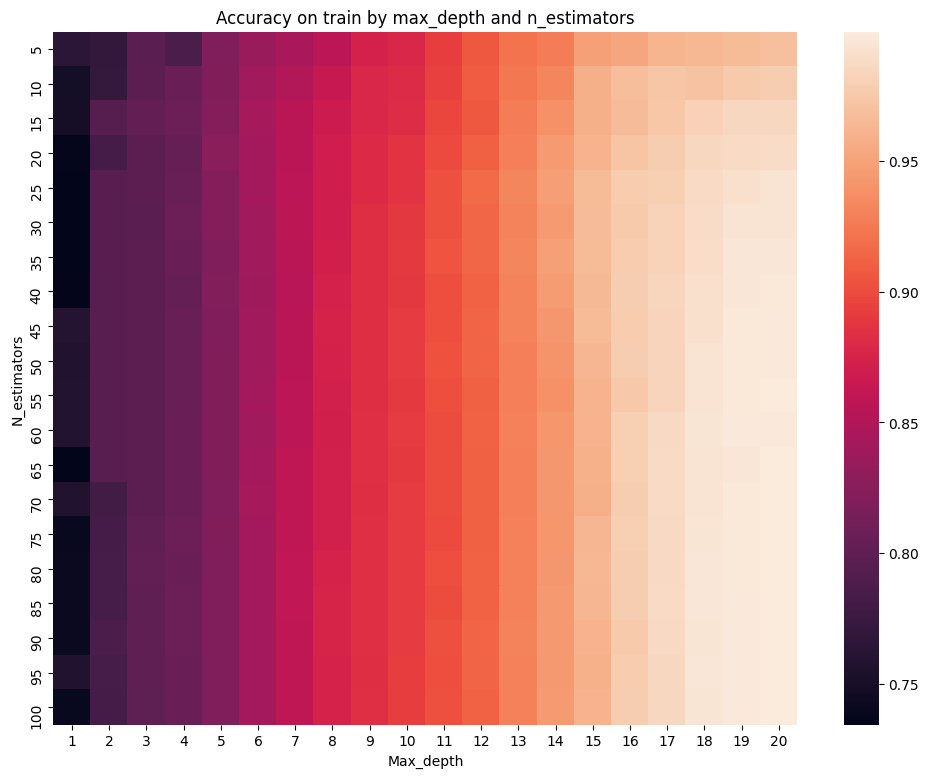

In [20]:
plt.figure(figsize=[12, 9])
plt.title('Accuracy on train by max_depth and n_estimators')
sns.heatmap(train_scores)
plt.xlabel('Max_depth')
plt.ylabel('N_estimators');

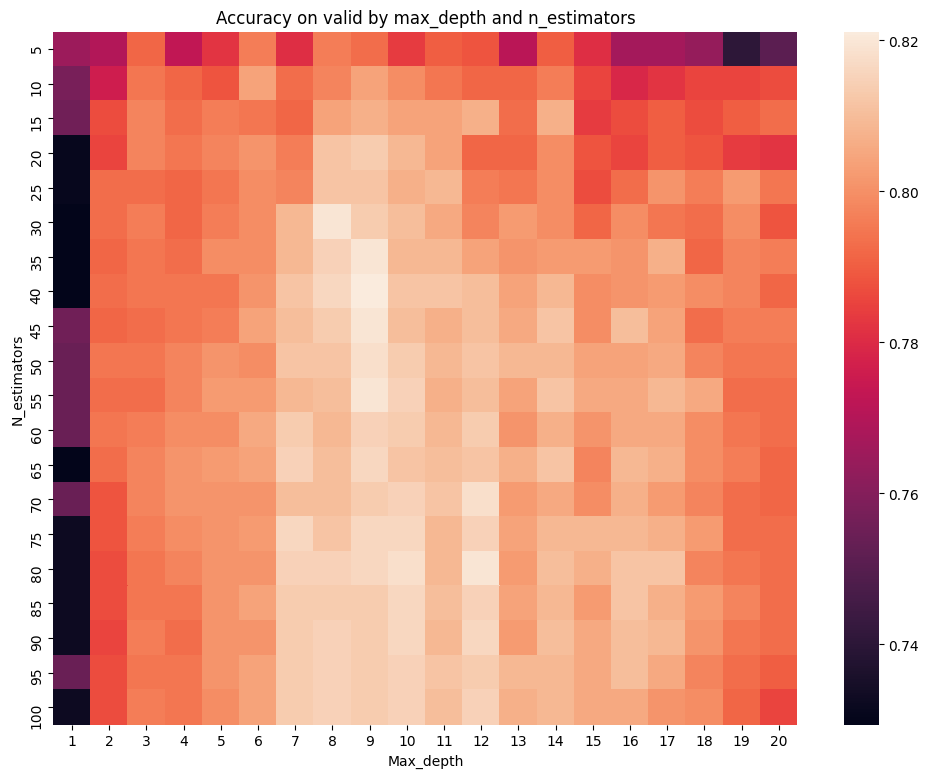

In [21]:
plt.figure(figsize=[12, 9])
plt.title('Accuracy on valid by max_depth and n_estimators')
sns.heatmap(valid_scores)
plt.xlabel('Max_depth')
plt.ylabel('N_estimators');

In [22]:
accuracy_score(y_valid[y_valid == 1], best_rf.predict(X_valid[y_valid == 1]))

0.5431472081218274

In [23]:
accuracy_score(y_valid[y_valid == 0], best_rf.predict(X_valid[y_valid == 0]))

0.9439461883408071

Для RandomForestClassifier лучшее значение accuracy на валидационной выборке равно 0.8212, достигается при max depth: 9, n_estimators: 40. Причем для тарифа "Ультра" accuracy равно всего лишь 0.5431, а для тарифа "Смарт" 0.9439. Возможно, так получилось, потому что в наборе данных гораздо меньше данных о пользователях с тарифом "Ультра".

По тепловой карте зависимости accuracy от max_depth и n_estimators видно, что прирост в основном приносит увеличение глубины дерева, чем количества деревьев, прирост идет плавно, самые высокие результаты показываются при самых больших показателях max_depth и n_estimators, а самые скромные при маленьких. 

Тепловая карта accuracy по max_depth и n_estimators для валидационной выборки менее однородна, имеет светлое пятно (самые высокие показатели accyracy) при глубине дерева 8-9, количестве деревьев 35-55. Видимо, для больших значений max_depth и n_estimators происходит переобучение модели.

### LogisticRegression

In [24]:
best_C = None
best_fit_intercept = None
best_score = 0
best_penalty = None
best_lr = None
for C in (0.01, 0.1, 1, 10, 100):
    for fit_intercept in (True, False):
        for penalty in ('l1', 'l2'):
            lr = LogisticRegression(penalty=penalty, 
                                    solver='liblinear', 
                                    C=C, 
                                    fit_intercept=fit_intercept, 
                                    n_jobs=-1, 
                                    random_state=12345)
            lr.fit(X_train, y_train)
            score = accuracy_score(y_valid, lr.predict(X_valid))
            if score > best_score:
                best_score = score
                best_C = C
                best_fit_intercept = fit_intercept
                best_penalty = penalty
                best_lr = lr
print(f'Best C: {best_C}, best fit_intercept: {best_fit_intercept}, best penalty: {best_penalty}, best accuracy on valid: {best_score}')        

Best C: 10, best fit_intercept: True, best penalty: l1, best accuracy on valid: 0.7402799377916018


In [25]:
accuracy_score(y_valid[y_valid == 1], best_lr.predict(X_valid[y_valid == 1]))

0.19796954314720813

In [26]:
accuracy_score(y_valid[y_valid == 0], best_dt.predict(X_valid[y_valid == 0]))

0.9327354260089686

Для LogisticRegression лучшее значение accuracy на валидационной выборке равно 0.7403. Причем для тарифа "Ультра" accuracy равно всего лишь 0.198, а для тарифа "Смарт" 0.9327. 

Лучшая модель из моделей LogisticRegression показала самые слабые значения accuracy, а лучшая модель из моделей RandomForestClassifier - самые сильные.

Лучшая модель RandomForestClassifier(max depth: 9, n_estimators: 40).

## Проверка модели на тестовой выборке

In [27]:
best_rf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8289269051321928

In [28]:
precision_score(y_test, y_pred)

0.8222222222222222

In [29]:
recall_score(y_test, y_pred)

0.5634517766497462

In [30]:
f1_score(y_test, y_pred)

0.6686746987951807

In [31]:
confusion_matrix(y_test, y_pred)

array([[422,  24],
       [ 86, 111]], dtype=int64)

Accuracy на тестовой выборке для лучшей модели (RandomForestClassifier(max depth=9, n_estimators=40)) 0.8289.

## Проверка модели на адекватность

In [32]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
accuracy_score(y_test, dc.predict(X_test))

0.6936236391912908

Наивный классификатор дает accuracy на тесте 0.6936, что на 0.1353 хуже, чем RandomForestClassifier, это хороший прирост. Выбранная лучшая модель адекватна. 